In [1]:
%autosave 60
%matplotlib inline

# fix UTF8 encoding with matplotlib
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.font_manager
import scipy.stats

Autosaving every 60 seconds


In [47]:
lang = 'en'

confidence = 95
results_dir = 'results'
switch_json = results_dir + '/switch_dataset.json'
iotp_json = results_dir + '/iotp_dataset.json'

lang = lang.lower()
data_map = {
    u'No Aggregation (L2 Switch)':   u'No Aggregation (UDP/IP)'   if lang == 'en' else u'Sem Agregação (UDP/IP)',
    u'No Aggregation (IoTP)':        u'No Aggregation (IoTP)'     if lang == 'en' else u'Sem Agregação (IoTP)',        
    u'L2 Switch DT 10':              u'E2E 10 data blocks (No Timer)' if lang == 'en' else u'E2E 10 blocos de dados', 
    u'L2 Switch DT 50':              u'E2E 50 data blocks (No Timer)' if lang == 'en' else u'E2E 50 blocos de dados',        
    u'IoTP DT 10':                   u'IoTP 10 data blocks (Non-SF)'       if lang == 'en' else u'IoTP 10 blocos de dados',
    u'IoTP DT 50':                   u'IoTP 50 data blocks (Non-SF)'       if lang == 'en' else u'IoTP 50 blocos de dados',        
    u'L2 Switch DT 10 w/ Sync Pkt':  u'E2E 10 data blocks (Timer)' if lang == 'en' else u'E2E 10 blocos de dados c/ Timer', 
    u'L2 Switch DT 50 w/ Sync Pkt':  u'E2E 50 data blocks (Timer)' if lang == 'en' else u'E2E 50 blocos de dados c/ Timer',    
    u'IoTP DT 10 w/ Sync Pkt':       u'IoTP 10 data blocks (SF)'   if lang == 'en' else u'IoTP 10 blocos de dados c/ SF',    
    u'IoTP DT 50 w/ Sync Pkt':       u'IoTP 50 data blocks (SF)'   if lang == 'en' else u'IoTP 50 blocos de dados c/ SF'
}
nm_map = {
    'aggregation_strategy': u'Aggregation Strategy' if lang == 'en' else u'Estratégia de Agregação',
    'avg_delay': u'Average Aggregation Delay (ms)'  if lang == 'en' else u'Atraso Médio de Agregação (ms)',    
    'avg_voltage': u'Average IoT Device Battery (V)'  if lang == 'en' else u'Bateria dos Dispositivos IoT (V)',    
    'devices':   u'Number of IoT Devices'           if lang == 'en' else u'Número de Dispositivos IoT',    
    'data_per_pkt': u'Data per Packet'              if lang == 'en' else u'Dados por Pacote',
    'goodput':  u'Total Payload Sent (Kbps)'        if lang == 'en' else u'Total de Carga Útil Enviada (Kbps)',
    'gt':       u'Network Efficiency (%)'           if lang == 'en' else u'Eficiência de Rede (%)',
    'pkt_loss': u'Packet Loss (%)'                  if lang == 'en' else u'Perda de Pacotes (%)', 
    'pkt_recv': u'Packets Sent by the Switch'       if lang == 'en' else u'Pacotes Enviados pelo Switch',
    'pkt_send': u'Packets Sent by IoT Devices'      if lang == 'en' else u'Pacotes Enviados pelos disp. IoT',
    'pps_recv': u'Packets Sent by the Switch (pps)' if lang == 'en' else u'Pacotes Enviados pelo Switch (pps)', 
    'pps_send': u'Packets Sent by IoT Devices (pps)' if lang == 'en' else u'Pacotes Enviados pelos disp. IoT (pps)', 
    'sample_int': u'Sampling Interval (s)'          if lang == 'en' else u'Intervalo de Amostragem (s)', 
    'throughput': u'Total Data Sent (Kbps)'         if lang == 'en' else u'Total de Dados Enviados (Kbps)',
    'topology':   u'Topology'                       if lang == 'en' else u'Topologia',
    'sync_flag':  u"IoTP's Packet Sync Flag Send Interval (s)" if lang == 'en' else u'Intervalo Envio Pct IoTP c/ Sync Flag (s)'
}
nm_keys = nm_map.keys()
nm_keys.sort()

df = pd.concat([
    pd.read_json(switch_json, orient='records', typ='frame', encoding='utf-8'), 
    pd.read_json(iotp_json, orient='records', typ='frame', encoding='utf-8')
])

# MANIPULA OS REGISTROS INDIVIDUAIS DE DADOS
def parse(x):
    x['goodput']    = x['goodput']    * 8 / 1024
    x['throughput'] = x['throughput'] * 8 / 1024
    if x['sync_flag'] == 0.1:
        x['aggregation_strategy'] += ' w/ Sync Pkt'
    return x
df = pd.DataFrame.from_records(map(parse, df.to_dict('records')))

# APLICA NOMES NOVOS NOMES PARA METRICAS E ESTRATEGIAS DE AGREGACAO
df.set_axis(map(lambda x: nm_map[x], nm_keys), axis=1, inplace=True)
df[ nm_map['aggregation_strategy'] ] = df[ nm_map['aggregation_strategy'] ].apply(lambda x: data_map[x])

In [48]:
# kurtosis
# < 0    The peak is lower and broader, lack of outliers
# > 0    Peak is higher and sharper, profusion of outliers
# skewness
# < |0.5|           fairly simmetrical
# [|0.5|, |1.0|]    moderate skew
# > |1.0|           high skew
def calculate_descriptive_stat(df):
    kur_skew = pd.concat([df.kurtosis() - 3, df.skew()], axis=1, keys=[u'Kurtosis Normalizado',u'Skewness']).transpose()
    stat = df.describe()
    conf_var = scipy.stats.t.ppf((1 + confidence/100.) / 2., stat.loc['count']-1) * stat.loc['std']
    conf_int = pd.concat([stat.loc['mean']-conf_var, stat.loc['mean']+conf_var], axis=1, keys=[u'Intervalo de Confiança - Limite Inferior',u'Intervalo de Confiança - Limite Superior']).transpose()
    stat.set_axis([u'Amostragem', u'Média', u'Desvio Padrão', u'Mínimo', u'1º Quartil', u'2º Quartil', u'3º Quartil', u'Máximo'], axis=0, inplace=True)
    stat = pd.concat([stat, conf_int])
    stat = pd.concat([stat, kur_skew])
    return stat

# calculate_descriptive_stat(df.loc[df[nm_map['aggregation_strategy']] == u'L2 Switch'])

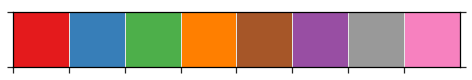

In [49]:
dpi = 400
fig_format = 'pdf'
capsize = 4
aspect_ratio = 0.58
# leg = {
#     'edgecolor': 'black'
#     # Put the legend out of the figure
#     # bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
# }

# style (defines grid style): darkgrid, whitegrid, dark, white, ticks
# palette (defines the color pallete): deep, muted, bright, pastel, dark, colorblind
# font: "serif", "sans-serif"
sns.set(
    context="notebook", 
#     style="whitegrid", 
    style="ticks",     
#     palette="muted", 
#     palette="colorblind",     
    palette="Set1",
    font=u"arial,Verdana,Noto Sans,Times New Roman,serif,sans-serif", 
    font_scale=1.00, 
    rc={
#         "lines.linewidth": 1.25, # plot line size of the 
        # axis color, 
        'axes.edgecolor': 'black', # default '.8'
        'axes.labelcolor': 'black', # default '.15'
        'text.color': 'black',    # default '.15' 
        # add grid
        'axes.grid': True,        
        'grid.color': '.9', # grid color, default '.8'        
#         'grid.linestyle': 'dotted', # default '-'
        'ytick.right': True, # add ticks to the right of y axis,
        # legend round corners
        "legend.fancybox": False,
        "legend.edgecolor": 'black',
    }
)
sns.set_palette([
     (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
     (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
     (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),     
     (1.0, 0.4980392156862745, 0.0),
     (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
     (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
     (0.6, 0.6, 0.6),     
     (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),     
])
sns.palplot(sns.color_palette())

def get_matplotlib_available_fonts():
    matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

def save_plot(filename, sns_axis):    
    # automatically adjust figure padding based on the font size
    #plt.tight_layout(pad=1.08)
    plt.tight_layout(pad=0.2)
    # make room for the xlabel in the saved figure (manual adjustment, not ideal)
    #plt.gcf().subplots_adjust(left=0.17, bottom=0.11, top=0.8)
    # save files    
    sns_axis.figure.savefig('%s/%s.%s' %(results_dir, filename, 'ps' if fig_format == 'eps' else fig_format),
                            format=fig_format, dpi=dpi)

def set_legend(legend, ax=None):
    new_title = None    
    if legend == None:
        legend = {}
    if legend != False:
        if 'title' in legend:        
            new_title = legend['title']        
            del legend['title']
        if ax != None:                        
            if new_title != None:
                handles, labels = ax.get_legend_handles_labels()            
                legend['handles'] = handles[1:]
                legend['labels'] = labels[1:]
                legend['title'] = new_title
            ax.legend(**legend)            
        else:
            plt.legend(**legend)            
    
def set_scale(ax, scale):    
    xscale, yscale = scale
    if xscale:        
        if 'scale' in xscale:
            ax.set_xscale(xscale['scale'])
        # define ticks major scale formatter
        if 'major_formatter' in xscale:
            ax.get_xaxis().set_major_formatter(xscale['major_formatter'])        
        if 'ticks' in xscale:            
            ax.set(xticks=xscale['ticks'])
        if 'lim' in xscale:
            ax.set(xlim=xscale['lim'])
    if yscale:                
        if 'scale' in yscale:
            ax.set_yscale(yscale['scale']) 
        # define ticks major scale formatter
        if 'major_formatter' in scale[1]:
            ax.get_yaxis().set_major_formatter(yscale['major_formatter'])        
        if 'ticks' in yscale:            
            ax.set(yticks=yscale['ticks'])
        if 'lim' in yscale:
            ax.set(ylim=yscale['lim'])                    

def show_lineplot(df, filename, x, y, hue, hue_order=None, capsize=capsize, ax=None, scale=[None, None], size=(6,6), legend=None):
    if size:
        plt.figure(figsize=size)
    if hue == 'aggregation_strategy' and hue_order:
        hue_order = map(lambda x: data_map[x], hue_order)    
    ax1 = sns.lineplot(x=nm_map[x], y=nm_map[y], ax=ax,           
            hue=nm_map[hue], hue_order=hue_order, style=nm_map[hue],
            markers=True, dashes=False, legend='brief' if legend != False else False,
            err_style='bars', ci=confidence, err_kws={'capsize':capsize},
            data=df)   
    if ax == None:
        ax = ax1
    set_legend(legend, ax=ax1)
    set_scale(ax, scale=scale)
    save_plot(filename, ax)
    return ax
    
def show_barplot(df, filename, x, y, ax=None, scale=[None, None], size=(6,6)):
    if size:
        plt.figure(figsize=size)
    ax = sns.barplot(x=nm_map[x], y=nm_map[y], ax=ax, 
                     estimator=np.mean, ci=confidence, capsize=capsize/18.0,
                     data=df)
    set_scale(ax, scale=scale)
    save_plot(filename, ax)
    return ax

def show_catplot(df, filename, x, y, hue, col=None, col_wrap=None, order=None, hue_order=None, share=(False,False), ax=None, scale=[None, None], size=(6,6), ticks=[None,None], capsize=0.25, legend=None):
    if hue == 'aggregation_strategy' and hue_order:
        hue_order = map(lambda x: data_map[x], hue_order)
    ax = sns.catplot(x=nm_map[x], y=nm_map[y], hue=nm_map[hue], col=col, col_wrap=col_wrap, data=df,
                     order=order, hue_order=hue_order, sharex=share[0], sharey=share[1],
                     estimator=np.mean, ci=confidence, capsize=capsize,
                    orient='v', height=size[1], aspect=float(size[0])/size[1], kind="bar", legend=False if legend != None else True)    
    if legend != None:
#         legend['title'] = nm_map[hue]
        set_legend(legend)
    set_scale(ax, scale=scale )
    ax.savefig('%s/%s.png' %(results_dir, filename), format='png', dpi=dpi)
    return ax

df_dpp10 = df[df[nm_map['data_per_pkt']] == 10 ]
df_dpp50 = df[df[nm_map['data_per_pkt']] == 50 ]
df_timer = df[ (df[nm_map['aggregation_strategy']] == data_map['L2 Switch DT 10 w/ Sync Pkt']) | (df[nm_map['aggregation_strategy']] == data_map['L2 Switch DT 50 w/ Sync Pkt']) ]
df_notimer = df[ (df[nm_map['data_per_pkt']] > 0) & (df[nm_map['aggregation_strategy']] != data_map['L2 Switch DT 10 w/ Sync Pkt']) & (df[nm_map['aggregation_strategy']] != data_map['L2 Switch DT 50 w/ Sync Pkt']) ]
df_noagg = df[ (df[nm_map['data_per_pkt']] == 0) ]
df_agg = df[ (df[nm_map['data_per_pkt']] > 0) ]

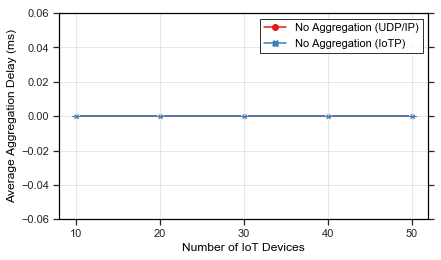

In [50]:
ax = show_lineplot(df_noagg, 'avg_delay_noagg_lineplot', x='devices', y='avg_delay', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.2,.55),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': map(lambda x: x / 50.0, xrange(-3,4)),
#     'lim': (30,2000)
}])

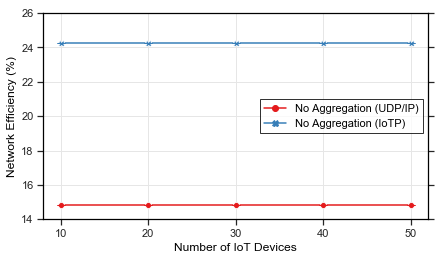

In [51]:
ax = show_lineplot(df_noagg, 'gt_noagg_lineplot', x='devices', y='gt', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.4,.5),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(14,28,2),
#     'lim': (30,2000),
}])

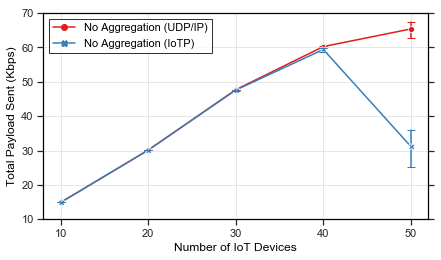

In [52]:
ax = show_lineplot(df_noagg, 'goodput_noagg_lineplot', x='devices', y='goodput', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.2,.55),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(10,80,10),
    'lim': (10,70),
}])

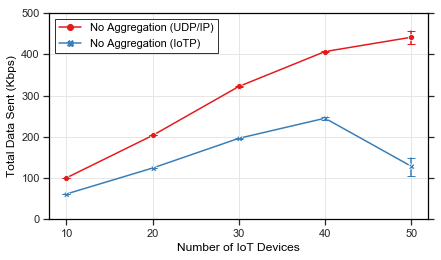

In [53]:
ax = show_lineplot(df_noagg, 'throughput_noagg_lineplot', x='devices', y='throughput', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.2,.55),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
#     'ticks': range(50,550,100),
    'lim': (0,500),
}])

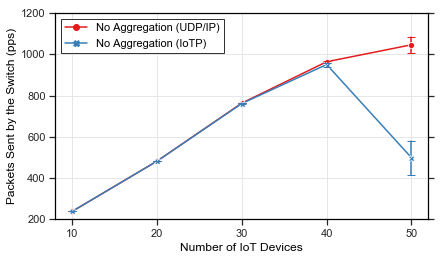

In [54]:
ax = show_lineplot(df_noagg, 'pkt_recv_noagg_lineplot', x='devices', y='pps_recv', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.2,.55),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(200,1400,200),
    'lim': (200,1200),
}])

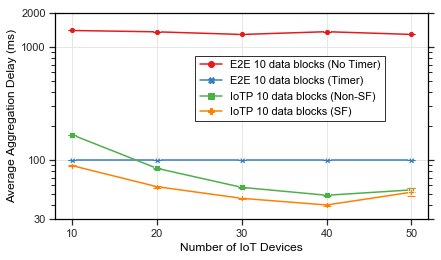

In [55]:
ax = show_lineplot(df_dpp10, 'avg_delay_agg10_lineplot', x='devices', y='avg_delay', hue='aggregation_strategy', legend={
    'title': '',
    'loc': (.375,.475),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
    'scale': 'log',
    'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': [30,100,1000,2000],
#     'lim': (30,2000)
}])

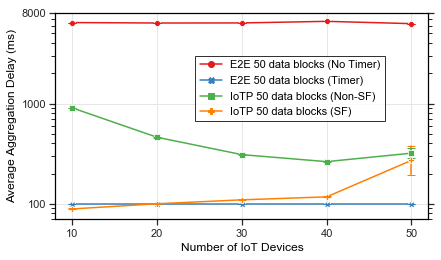

In [56]:
ax = show_lineplot(df_dpp50, 'avg_delay_agg50_lineplot', x='devices', y='avg_delay', hue='aggregation_strategy', legend={
    'title': '',
    'loc': (.375,.475),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
    'scale': 'log',
    'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': [100,1000,8000],
    'lim': (70,8000)
}])

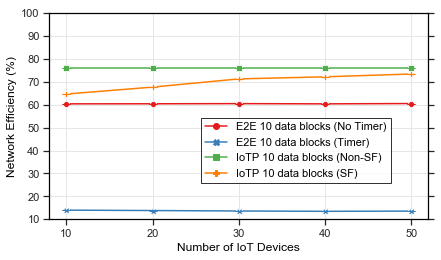

In [57]:
ax = show_lineplot(df_dpp10, 'gt_agg10_lineplot', x='devices', y='gt', hue='aggregation_strategy', legend={
    'title': '',
    'loc': (.4,.175),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
    'lim': (10,100),
}])

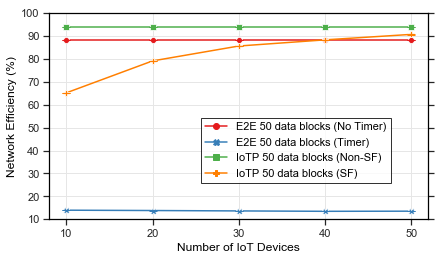

In [58]:
ax = show_lineplot(df_dpp50, 'gt_agg50_lineplot', x='devices', y='gt', hue='aggregation_strategy', legend={
    'title': '',
    'loc': (.4,.175),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
#     'ticks': range(10,110,15),
    'lim': (10,100),
}])

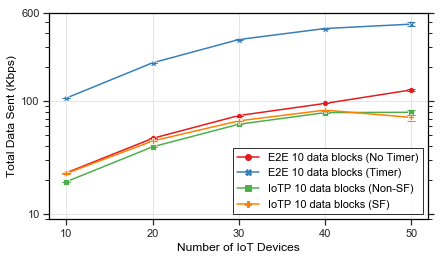

In [59]:
ax = show_lineplot(df_dpp10, 'throughput_agg10_lineplot', x='devices', y='throughput', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.202,.0),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
    'scale': 'log',
    'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': [10,100,600],
    'lim':   (9,600),
}])

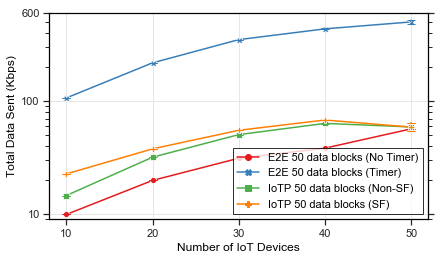

In [60]:
ax = show_lineplot(df_dpp50, 'throughput_agg50_lineplot', x='devices', y='throughput', hue='aggregation_strategy', legend={
    'title': '',
    'loc': 'lower right' #(.202,.0),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
    'scale': 'log',
    'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': [10,100,600],
    'lim':   (9,600),
}])

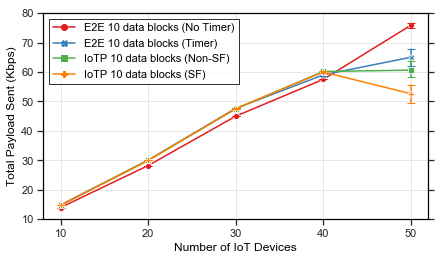

In [61]:
ax = show_lineplot(df_dpp10, 'goodput_agg10_lineplot', x='devices', y='goodput', hue='aggregation_strategy', legend={
    'title': '',
    'loc': 'upper left' #(.225,.025),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(10,90,10),
    'lim': (10,80),
}])

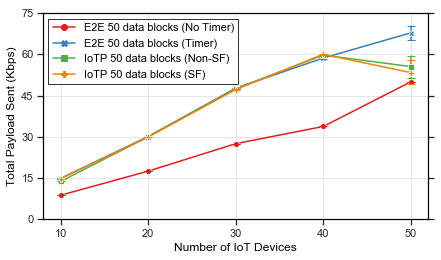

In [62]:
ax = show_lineplot(df_dpp50, 'goodput_agg50_lineplot', x='devices', y='goodput', hue='aggregation_strategy', legend={
    'title': '',
    'loc': 'upper left' #(.025,.705),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(0,90,15),    
    'lim': (0,75),
}])

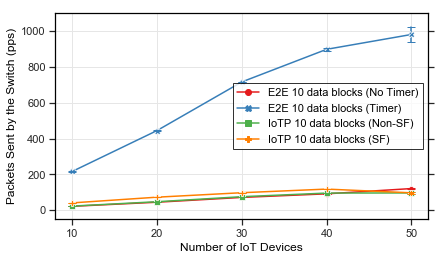

In [63]:
ax = show_lineplot(df_dpp10, 'pkt_recv_agg10_lineplot', x='devices', y='pps_recv', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.225,.2),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(0,1300,200),
    'lim': (-50,1100),    
}])

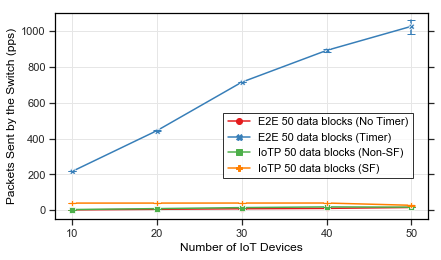

In [64]:
ax = show_lineplot(df_dpp50, 'pkt_recv_agg50_lineplot', x='devices', y='pps_recv', hue='aggregation_strategy', legend={
    'title': '',
    'loc': (.45,.20),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
#     'ticks': range(0,1200,150),
    'lim': (-50,1100),    
}])

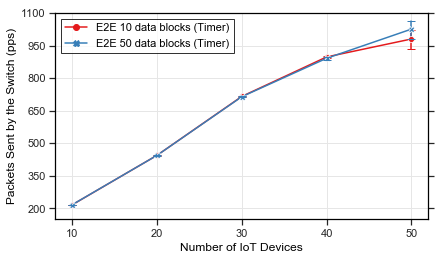

In [65]:
ax = show_lineplot(df_timer, 'pkt_recv_timer_lineplot', x='devices', y='pps_recv', hue='aggregation_strategy', legend={
    'title': '',
#     'loc': (.225,.025),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(200,1300,150),
    'lim': (150,1100),        
}])

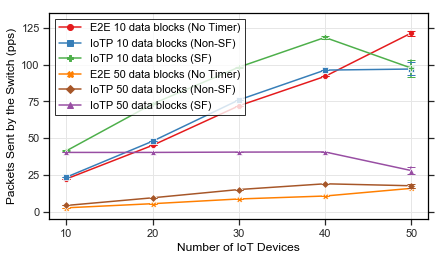

In [66]:
# sns.set_palette([
#      (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
#      (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
#      (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),     
#      (1.0, 0.4980392156862745, 0.0),
#      (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
#      (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
#      (0.6, 0.6, 0.6),     
#      (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),     
# ])
# sns.palplot(sns.color_palette())

ax = show_lineplot(df_notimer, 'pkt_recv_notimer_lineplot', x='devices', y='pps_recv', hue='aggregation_strategy', 
hue_order=[
    'L2 Switch DT 10',        
    'IoTP DT 10',
    'IoTP DT 10 w/ Sync Pkt',
    'L2 Switch DT 50',    
    'IoTP DT 50',    
    'IoTP DT 50 w/ Sync Pkt',
],
legend={    
    'title': '',
#     'loc': (.225,.15),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': range(0,150,25),    
    'lim': (-5,135),    
}])


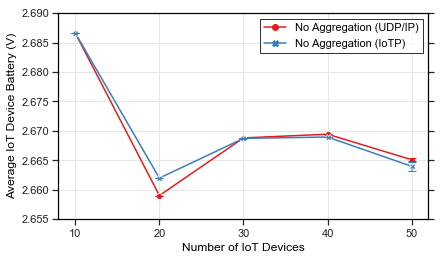

In [67]:
ax = show_lineplot(df_noagg, 'avg_voltage_noagg_lineplot', x='devices', y='avg_voltage', hue='aggregation_strategy', 
# hue_order=[
#     'L2 Switch DT 10',        
#     'IoTP DT 10',
#     'IoTP DT 10 w/ Sync Pkt',
#     'L2 Switch DT 50',    
#     'IoTP DT 50',    
#     'IoTP DT 50 w/ Sync Pkt',
# ],
legend={    
    'title': '',
#     'loc': (.225,.15),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': np.arange(2.655,2.690,.005),    
    'lim': (2.655,2.690),    
}])

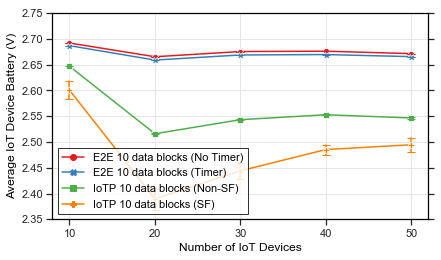

In [68]:

ax = show_lineplot(df_dpp10, 'avg_voltage_agg10_lineplot', x='devices', y='avg_voltage', hue='aggregation_strategy', 
# hue_order=[
#     'L2 Switch DT 10',        
#     'IoTP DT 10',
#     'IoTP DT 10 w/ Sync Pkt',
#     'L2 Switch DT 50',    
#     'IoTP DT 50',    
#     'IoTP DT 50 w/ Sync Pkt',
# ],
legend={    
    'title': '',
#     'loc': (.465,.05),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
    'ticks': np.arange(2.350,2.800,.050),    
    'lim': (2.350,2.750),    
}])

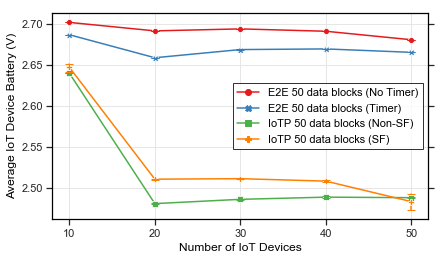

In [72]:
# sns.palplot(sns.hls_palette(8, l=.3, s=.8))

ax = show_lineplot(df_dpp50, 'avg_voltage_agg50_lineplot', x='devices', y='avg_voltage', hue='aggregation_strategy', 
# hue_order=[
#     'L2 Switch DT 10',        
#     'IoTP DT 10',
#     'IoTP DT 10 w/ Sync Pkt',
#     'L2 Switch DT 50',    
#     'IoTP DT 50',    
#     'IoTP DT 50 w/ Sync Pkt',
# ],
legend={    
    'title': '',
#     'loc': (.125,.15),
}, size=(6,6*aspect_ratio), scale=[{'ticks': range(10,60,10)}, {
#     'scale': 'log',
#     'major_formatter': matplotlib.ticker.ScalarFormatter(),
#     'ticks': np.arange(2.350,2.800,.050),    
#     'lim': (2.350,2.750),    
}])

In [70]:
# ax = show_catplot( df, 'throughput_catplot', capsize=0.09, size=(7,6), ticks=[None, (0,16800,1500)], x='devices', y='throughput', hue='aggregation_strategy', hue_order=['Sensor 10 data bcks', 'IoTP 10 data bcks', 'IoTP 10 data bcks w/ Sync Pkt', 'Sensor 50 data bcks', 'IoTP 50 data bcks', 'IoTP 50 data bcks w/ Sync Pkt'])
# ax = show_catplot( df, 'pkt_recv_noaggregation_catplot', ticks=[None, (0,11001,1000)], x='devices', y='pkt_recv', hue='aggregation_strategy', hue_order=['No Aggregation (UDP/IP)', 'No Aggregation (IoTP)'])


In [71]:
# if barplot:
#     ax = show_barplot(df, 'delay_iotp_barplot', x='aggregation_strategy', y='avg_delay', size=(11,7), scale_lim=[None, None])
# else:
#     ax = show_lineplot(df, 'delay_iotp_lineplot', x='pps_tcpreplay', y='avg_delay', category='aggregation_strategy')    